In [1]:
import numpy as np;import skimage
import cv2;import matplotlib.pyplot as plt

def srgb_to_lrgb(srgb):# sRGB↔輝度リニア変換(簡易版)
    return skimage.exposure.adjust_gamma(srgb,2.2)
def lrgb_to_srgb(linear):
    return skimage.exposure.adjust_gamma(
        np.clip(linear,0.0,1.0),1/2.2)
RGB_TO_XYZ=np.array(#SRGB値⇒XYZ値の変換行列
    [[0.41245, 0.35758, 0.18042],
    [0.21267, 0.71516, 0.07217],
    [0.01933, 0.11919, 0.95023]])
XYZ_TO_RGB=np.array(#XYZ値⇒SRGB値の変換行列
    [[3.24048, -1.53715, -0.49854],
    [-0.96926, 1.87599, 0.041556],
    [0.05565, -0.20404, 1.05731]])
def srgb_to_xyz(srgb): # sRGB⇒輝度リニアRGB⇒XYZ
    return srgb_to_lrgb(srgb) @ RGB_TO_XYZ.T
def xyz_to_srgb(xyz):  # XYZ⇒輝度リニアRGB⇒sRGB
    return lrgb_to_srgb(xyz@XYZ_TO_RGB.T)
def xyz_to_lms(xyz,M):# XYZ刺激値⇒LMS錐体の刺激値
    return xyz@M.T
def normalize_xyz(xyz):# 輝度値(Y)で正規化
    return xyz/xyz[1]

In [2]:
def ave_srgb(img):#RGB各色の平均を輝度リニア値で算出⇒sRGBで返す
    return lrgb_to_srgb(srgb_to_lrgb(img).mean((0,1)))
def chromatic_adaptation(# sRGB画像に「見え」調整を行う
    src_white_point,dst_white_point,src_img, adapt):
    src_img_xyz=srgb_to_xyz(src_img) # sRGB画像⇒XYZ画像
    # 撮影シーンの白色(XYZ値)
    xyz_src=normalize_xyz(srgb_to_xyz(src_white_point))
    # 観察環境の白色(XYZ値)
    xyz_dst=normalize_xyz(srgb_to_xyz(dst_white_point))
    XYZ_TO_LMS=np.array(#XYZ値⇒LMS値への変換行列(CAT02)
    [[0.733, 0.430, -0.162],
    [-0.704, 1.698, 0.006],
    [0.003, 0.014, 0.983]])
    # 撮影シーン白色と観察環境白色のLMS比で乗算係数gを算出
    lms_src = xyz_to_lms(xyz_src,XYZ_TO_LMS)
    lms_dst = xyz_to_lms(xyz_dst,XYZ_TO_LMS)
    g=(adapt*lms_dst+(1.0-adapt)*lms_src)/lms_src
    # XYZ値に対し(LMS値上で)「見え」を調整する変換行列を作る
    adapt_mat=np.linalg.inv(XYZ_TO_LMS)@np.diag(g)@XYZ_TO_LMS
    adapt_xyz=src_img_xyz@adapt_mat.T # 色調整を行う
    return xyz_to_srgb(adapt_xyz)# sRGB画像として返す

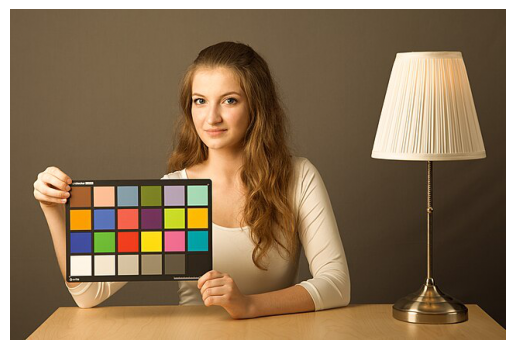

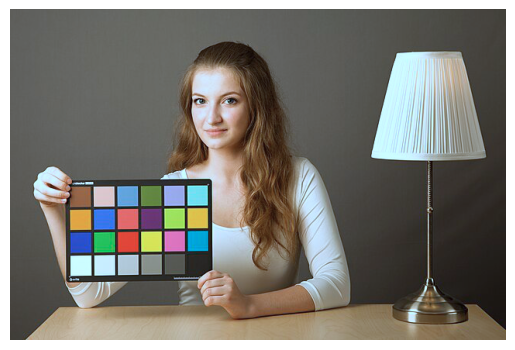

In [3]:
img=cv2.imread('original.jpg')
img=img[:,:,::-1]/255 # RGB順&0〜1範囲に収める
dst_white_point=np.array([1.,1.,1.])# 画面表示の色条件
src_white_point=ave_srgb(img) 
adapt_img=chromatic_adaptation(
    src_white_point,dst_white_point,img,1.0)
plt.axis('off');plt.imshow(img);plt.show()
plt.axis('off');plt.imshow(adapt_img);plt.show()

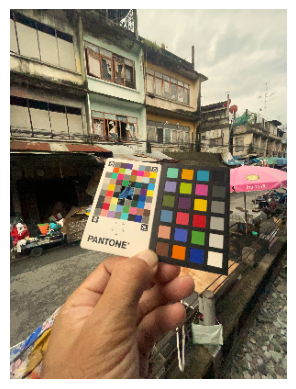

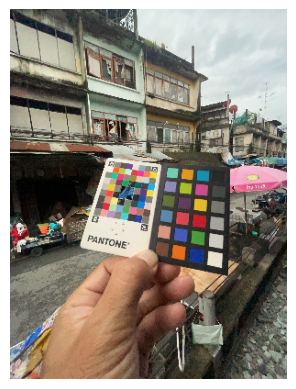

In [4]:
img=cv2.imread('IMG_5061.png')
h,w,ch=img.shape;h=int(h/10);w=int(w/10)
img=cv2.resize(img,(w,h))
img=img[:,:,::-1]/255 # RGB順&0〜1範囲に収める
dst_white_point=np.array([1.,1.,1.])# 画面表示の色条件
src_white_point=ave_srgb(img) 
adapt_img=chromatic_adaptation(
    src_white_point,dst_white_point,img,0.5)
plt.axis('off');plt.imshow(img);plt.show()
plt.axis('off');plt.imshow(adapt_img);plt.show()

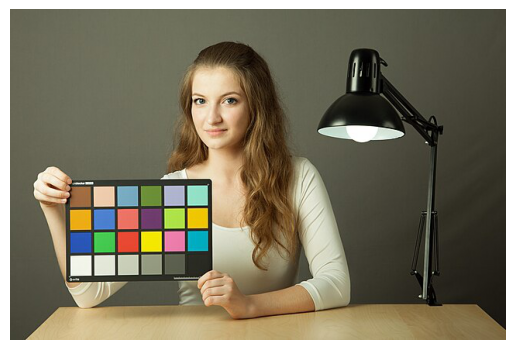

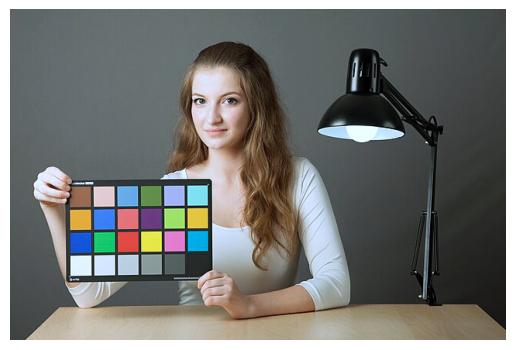

In [5]:
img = cv2.imread('640px-Wb_girl_cold.jpg')
r_img = img[:, :, ::-1] / 255
src_white_point = ave_srgb(r_img)
dst_white_point = np.array([1.0, 1.0, 1.0])
ca_img = chromatic_adaptation(src_white_point,dst_white_point,r_img,1.0)
ca_img = (ca_img * 255).astype(np.uint8)

plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

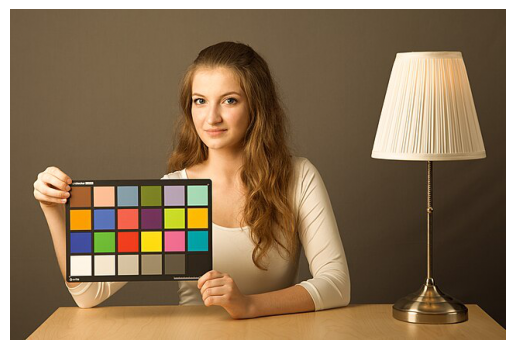

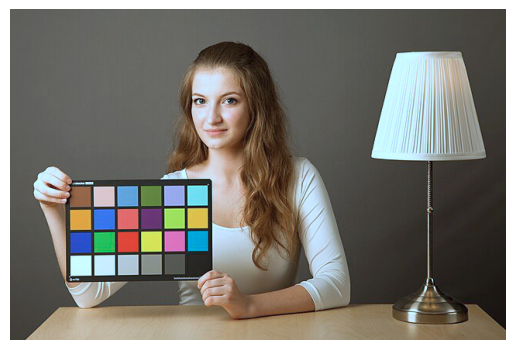

In [6]:
img = cv2.imread('640px-Wb_girl_warm.jpg')

r_img = img[:, :, ::-1] / 255
src_white_point = ave_srgb(r_img)
dst_white_point = np.array([1.0, 1.0, 1.0])
ca_img = chromatic_adaptation(src_white_point, dst_white_point, r_img, 1.0)
ca_img = (ca_img * 255).astype(np.uint8)
plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

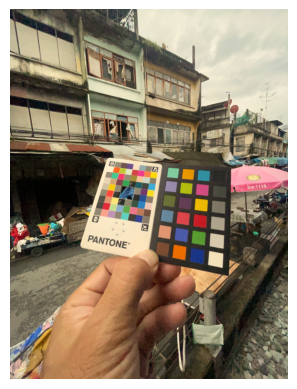

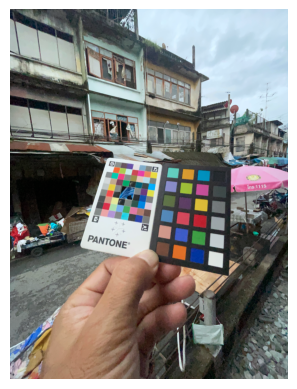

In [7]:
img = cv2.imread('IMG_5061.png')
r_img = img[:, :, ::-1] / 255
# 入力画像の照明条件と、観察時の照明条件を設定する
src_white_point = ave_srgb(r_img)
dst_white_point = np.array([1.0, 1.0, 1.0])
ca_img = chromatic_adaptation(src_white_point, dst_white_point, r_img, 1.0)
ca_img = (ca_img * 255).astype(np.uint8)
plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

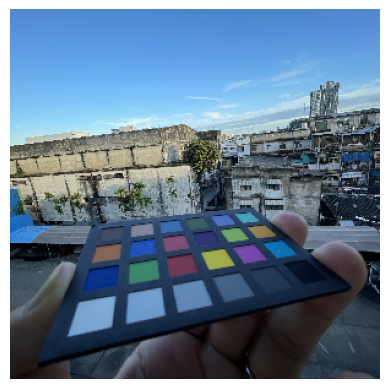

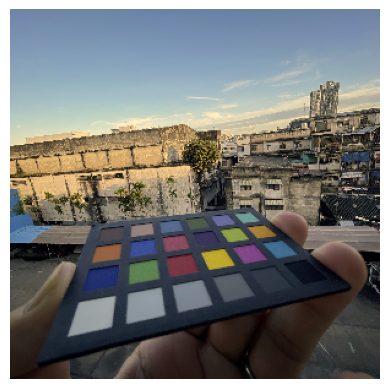

In [8]:
img = cv2.imread('IMG_5102.jpg')

# 処理時間短縮のため、画像サイズを小さくする
h,w,ch=img.shape
h=int(h/10); w=int(w/10)
img=cv2.resize(img,(w,h))
r_img = img[:, :, ::-1] / 255
src_white_point = np.array([130, 165, 205])/255
dst_white_point = np.array([1.0, 1.0, 1.0])
# 色順応させる
ca_img = chromatic_adaptation(src_white_point, dst_white_point, r_img,1.0)
ca_img = (ca_img * 255).astype(np.uint8)

plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

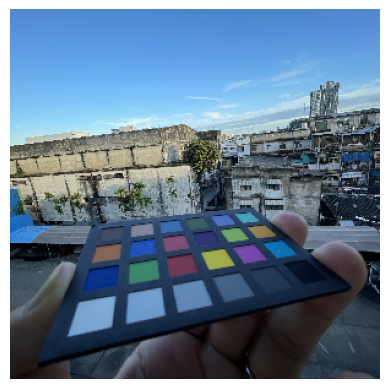

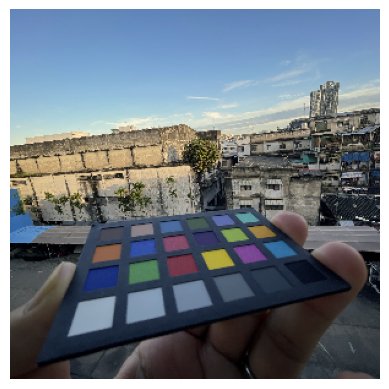

In [9]:
img = cv2.imread('IMG_5102.jpg')

# 処理時間短縮のため、画像サイズを小さくする
h,w,ch=img.shape
h=int(h/10); w=int(w/10)
img=cv2.resize(img,(w,h))
r_img = img[:, :, ::-1] / 255
src_white_point = np.array([130, 165, 205])/255
dst_white_point = np.array([1.0, 1.0, 1.0])
# 色順応させる
ca_img = chromatic_adaptation(src_white_point, dst_white_point, r_img,0.6)
ca_img = (ca_img * 255).astype(np.uint8)

plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

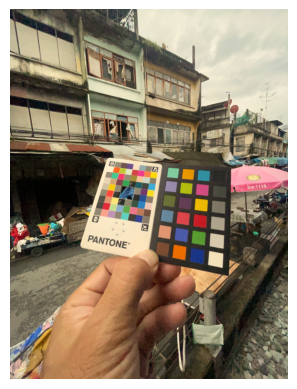

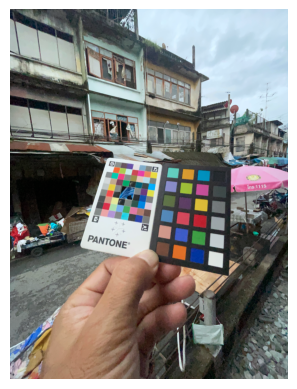

In [10]:
# read image which generally in sRGB format
img = cv2.imread('IMG_5061.png')
r_img = img[:, :, ::-1] / 255
# 入力画像の照明条件と、観察時の照明条件を設定する
src_white_point = ave_srgb(r_img)
dst_white_point = np.array([1.0, 1.0, 1.0])
ca_img = chromatic_adaptation(src_white_point, dst_white_point, r_img, 1.0)
ca_img = (ca_img * 255).astype(np.uint8)
plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

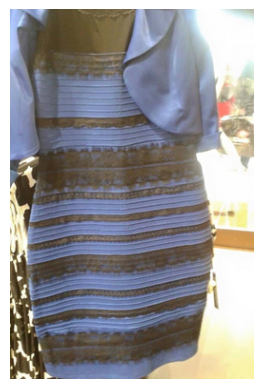

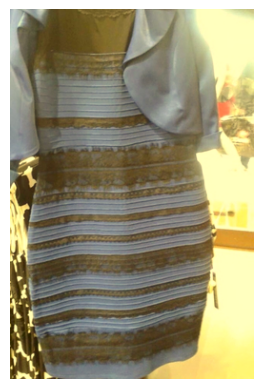

In [50]:
img = cv2.imread('The_dress_blueblackwhitegold.jpg')
r_img = img[:, :, ::-1] / 255

src_white_point=np.array([0.15,0.16,0.21])
src_white_point=np.array([150,160,210])/255

dst_white_point = np.array([1.0, 1.0, 1.0])
ca_img = chromatic_adaptation_image(src_white_point, dst_white_point, r_img, 1.0)
ca_img = (ca_img * 255).astype(np.uint8)

plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

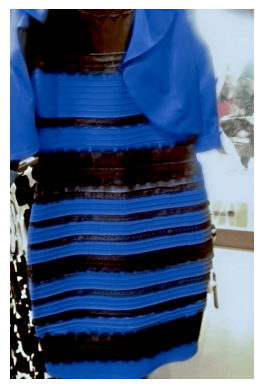

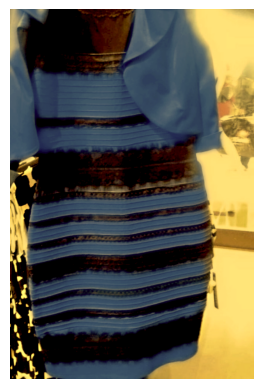

In [51]:
img = cv2.imread('original.png')

r_img = img[:, :, ::-1] / 255
src_white_point=np.array([45,65,115])/255

dst_white_point = np.array([1.0, 1.0, 1.0])
ca_img = chromatic_adaptation_image(src_white_point, dst_white_point, r_img, 1.0)
ca_img = (ca_img * 255).astype(np.uint8)

plt.axis('off'); plt.imshow(r_img);plt.show()
plt.axis('off'); plt.imshow(ca_img);plt.show()

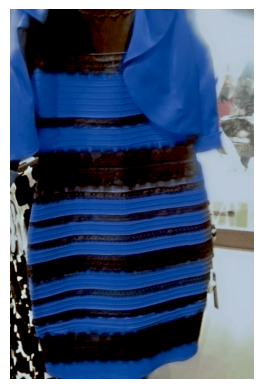

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


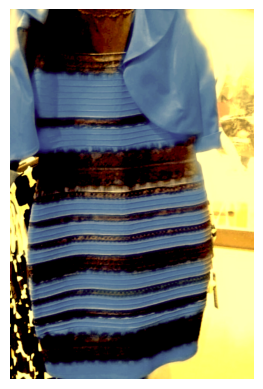

In [30]:
img=cv2.imread('original.png')
img=img[:,:,::-1]/255 # RGB順&0〜1範囲に収める
dst_white_point=np.array([1.,1.,1.])# 画面表示の色条件
src_white_point=ave_srgb(img) 
src_white_point=np.array([45,65,115])/255
adapt_img=chromatic_adaptation_image(
    src_white_point,dst_white_point,img,1.0)
plt.axis('off');plt.imshow(img*0.9);plt.show()
plt.axis('off');plt.imshow(adapt_img*1.5);plt.show()